In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import keras
import tensorflow as tf
import keras
from keras.metrics import categorical_accuracy
from keras import layers
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, balanced_accuracy_score
import datetime

In [2]:
df = pd.read_parquet('../data/train_pos.parquet')

In [3]:
encoder = tf.keras.layers.TextVectorization(max_tokens=20000)
encoder.adapt(df.from_tokens.values)

In [4]:
encoder.vocabulary_size()

20000

In [5]:
df = df[~(df.from_tokens == '')]

In [6]:
df.shape

(17473, 9)

In [7]:
X = df.clean.values
y = df.user_suggestion.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [9]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", dtype=tf.string, input_shape=[],
                  output_shape=[50]),
    keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    # keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
    
    
])
model.layers[0].trainable=True

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [11]:
callback_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, min_delta=0.005)

learning_drop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.80,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.01,
    cooldown=0,
    min_lr=0,
)

model_dir = "models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_dir, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)


In [14]:
# weights = dict(1/df.outcome.value_counts())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, 
          callbacks=[learning_drop, callback_stop, checkpoint_cb], batch_size=64)

Epoch 1/2
246/246 [==============================] - 26s 106ms/step - loss: 0.1969 - accuracy: 0.9255 - val_loss: 0.3115 - val_accuracy: 0.8804 - lr: 6.4000e-05
Epoch 2/2
246/246 [==============================] - 35s 142ms/step - loss: 0.1896 - accuracy: 0.9293 - val_loss: 0.3104 - val_accuracy: 0.8810 - lr: 6.4000e-05


In [34]:
model_best = keras.models.load_model('./models/20220205-190208.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [35]:
y_pred = (model_best.predict(X_test) > 0.5)
y_pred = np.squeeze(y_pred)

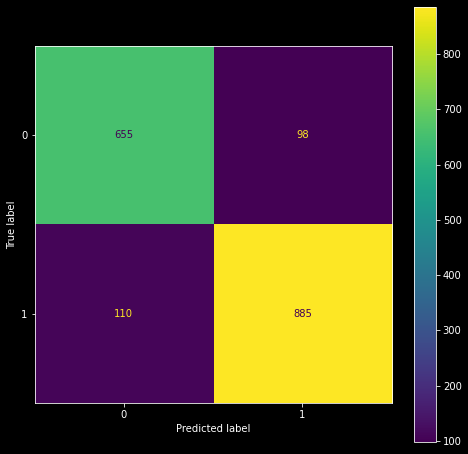

In [36]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       753
           1       0.90      0.89      0.89       995

    accuracy                           0.88      1748
   macro avg       0.88      0.88      0.88      1748
weighted avg       0.88      0.88      0.88      1748



In [38]:
fig.savefig('confusion.png', transparent=True)

In [39]:
df

,review_id,title,year,user_review,user_suggestion,clean,tokens,emoticon,from_tokens
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,i m scared and hearing creepy voices so i ll p...,"[scare, hear, creepi, voic, paus, moment, revi...",[Surprise],scare hear creepi voic paus moment review hear...
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,best game more better than sam pepper s youtub...,"[best, game, better, sam, pepper, youtub, acco...","[Skeptical, annoyed, undecided, uneasy or hesi...",best game better sam pepper youtub account pla...
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,a littly iffy on the controls but once you kno...,"[litt, iffi, control, easi, master, floor, due...",[],litt iffi control easi master floor due certai...
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,great game fun and colorful and all that a sid...,"[great, game, fun, color, side, note, get, win...",[],great game fun color side note get window mode...
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,not many games have the cute tag right next to...,"[mani, game, cute, tag, right, next, horror, t...",[],mani game cute tag right next horror tag steam...
...,...,...,...,...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1,arguably the single greatest mmorp that exists...,"[arguabl, singl, greatest, mmorp, exist, today...","[:heart_suit:, Wink or smirk]",arguabl singl greatest mmorp exist today free ...
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1,an older game to be sure but has its own charm...,"[older, game, sure, charm, special, place, hea...",[],older game sure charm special place heart play...
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1,when i frist started playing everquest it was ...,"[frist, start, play, everquest, amaz, still, g...",[],frist start play everquest amaz still great pl...
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1,cool game the only thing that really pisses me...,"[cool, game, thing, realli, ridabl, transport,...",[],cool game thing realli ridabl transport scenic...
